In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor


from sklearn.model_selection import RepeatedKFold, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RepeatedKFold
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn import linear_model

import scipy.stats as stats
from scipy.stats import pointbiserialr, spearmanr, skew, pearsonr

In [2]:
# load dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/housing.csv'
df = pd.read_csv(url, header=None)
# summarize shape
print(df.shape)
# summarize first few lines
df.head()

(506, 14)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2


Concerns housing values in suburbs of Boston.
1. CRIM      per capita crime rate by town
2. ZN        proportion of residential land zoned for lots over 
             25,000 sq.ft.
3. INDUS     proportion of non-retail business acres per town
4. CHAS      Charles River dummy variable (= 1 if tract bounds 
             river; 0 otherwise)
5. NOX       nitric oxides concentration (parts per 10 million)
6. RM        average number of rooms per dwelling
7. AGE       proportion of owner-occupied units built prior to 1940
8. DIS       weighted distances to five Boston employment centres
9. RAD       index of accessibility to radial highways
10. TAX      full-value property-tax rate per \$10,000 
11. PTRATIO  pupil-teacher ratio by town
12. B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks 
             by town
13. LSTAT    % lower status of the population
14. MEDV     Median value of owner-occupied homes in \$1000's

In [3]:
columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX', 'PTRATIO','B','LSTAT','MEDV']
df.columns = columns

In [4]:
df.head(3)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7


## Data analysis

In [5]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [6]:
categorical_var = ['CHAS']
numerical_var = [x for x in df.columns if x not in categorical_var]

In [11]:
sns.pairplot(data=df[numerical_var])

In [9]:
skewness = {x:round(df[x].skew(), 2) for x in df.columns}
kurtosis = {x:round(df[x].kurtosis(), 2) for x in df.columns}

In [10]:
skewness

{'CRIM': 5.22,
 'ZN': 2.23,
 'INDUS': 0.3,
 'CHAS': 3.41,
 'NOX': 0.73,
 'RM': 0.4,
 'AGE': -0.6,
 'DIS': 1.01,
 'RAD': 1.0,
 'TAX': 0.67,
 'PTRATIO': -0.8,
 'B': -2.89,
 'LSTAT': 0.91,
 'MEDV': 1.11}

We see that CRIM, B and ZN are highly skewed

In [16]:
df.isna().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

## Running XGBoost first cut

In [17]:
# split data into input and output columns
X, y = df.drop(['MEDV'], axis=1), df['MEDV']

In [18]:
X

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,0.06263,0.0,11.93,0,0.573,6.593,69.1,2.4786,1,273.0,21.0,391.99,9.67
502,0.04527,0.0,11.93,0,0.573,6.120,76.7,2.2875,1,273.0,21.0,396.90,9.08
503,0.06076,0.0,11.93,0,0.573,6.976,91.0,2.1675,1,273.0,21.0,396.90,5.64
504,0.10959,0.0,11.93,0,0.573,6.794,89.3,2.3889,1,273.0,21.0,393.45,6.48


In [19]:
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=10, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 2.129 (0.303)


In [20]:
# define model
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 2.109 (0.320)


## Clean the data

### Feature Scaling

In [21]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 25)

In [23]:
X_train.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
456,4.66883,0.0,18.10,0,0.713,5.976,87.9,2.5806,24,666.0,20.2,10.48,19.01
334,0.03738,0.0,5.19,0,0.515,6.310,38.5,6.4584,5,224.0,20.2,389.40,6.75
483,2.81838,0.0,18.10,0,0.532,5.762,40.3,4.0983,24,666.0,20.2,392.92,10.42
326,0.30347,0.0,7.38,0,0.493,6.312,28.9,5.4159,5,287.0,19.6,396.90,6.15
487,4.83567,0.0,18.10,0,0.583,5.905,53.2,3.1523,24,666.0,20.2,388.22,11.45


In [24]:
X_train.dtypes

CRIM       float64
ZN         float64
INDUS      float64
CHAS         int64
NOX        float64
RM         float64
AGE        float64
DIS        float64
RAD          int64
TAX        float64
PTRATIO    float64
B          float64
LSTAT      float64
dtype: object

In [25]:
categorical_var = ['CHAS']
numerical_var = [x for x in X_train.columns if x not in categorical_var]

In [26]:
X_train_log = X_train.copy()
X_test_log = X_test.copy()
# log transform those variables that are highly skewwed
for col in numerical_var:
    if skew(X[col])>1.5:
        X_train_log[col] = np.log1p(X_train_log[col])
        X_test_log[col] = np.log1p(X_test_log[col])
    else:
        pass     

In [28]:
skew(X_train_log['CRIM'])

1.1974035035978028

In [56]:
# we use standard scaler since we have some ver
feature_standarizer = StandardScaler()
feature_standarizer.fit(X_train[numerical_var])

X_train_scaled = pd.DataFrame(feature_standarizer.transform(X_train[numerical_var]),
                  columns=numerical_var,
                  index=X_train.index)
X_test_scaled = pd.DataFrame(feature_standarizer.transform(X_test[numerical_var]),
                  columns=numerical_var,
                  index=X_test.index)

In [58]:
X_train_scaled = X_train_scaled.join(X_train[categorical_var])
X_test_scaled = X_test_scaled.join(X_test[categorical_var])

In [59]:
X_train_scaled

,CRIM,ZN,INDUS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,CHAS
456,0.844927,-0.606975,1.060654,1.287822,-0.443792,0.702878,-0.580787,1.630462,1.536853,0.797604,-3.964821,0.822468,0
334,-0.777450,-0.606975,-0.852476,-0.358900,0.018330,-1.027462,1.196936,-0.533966,-1.087319,0.797604,0.356886,-0.812859,0
483,0.467432,-0.606975,1.060654,-0.217514,-0.739881,-0.964413,0.114982,1.630462,1.536853,0.797604,0.397033,-0.323328,0
326,-0.559324,-0.606975,-0.527940,-0.541869,0.021097,-1.363723,0.719017,-0.533966,-0.713286,0.534154,0.442426,-0.892891,0
487,0.872637,-0.606975,1.060654,0.206641,-0.542027,-0.512564,-0.318699,1.630462,1.536853,0.797604,0.343428,-0.185939,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,-0.602998,-0.606975,-0.154502,-0.117713,-0.712210,0.135438,0.084450,-0.647883,-0.612356,0.007253,0.442426,0.412969,0
143,0.743424,-0.606975,1.279975,2.601873,-1.146659,1.126706,-1.116606,-0.533966,-0.024589,-1.617357,0.442426,1.810867,0
474,1.292411,-0.606975,1.060654,0.214958,-1.203386,0.965581,-0.649919,1.630462,1.536853,0.797604,-0.063058,0.706421,0
318,-0.489698,-0.606975,-0.154502,-0.117713,0.117949,-0.022184,-0.144401,-0.647883,-0.612356,0.007253,0.423151,-0.331331,0


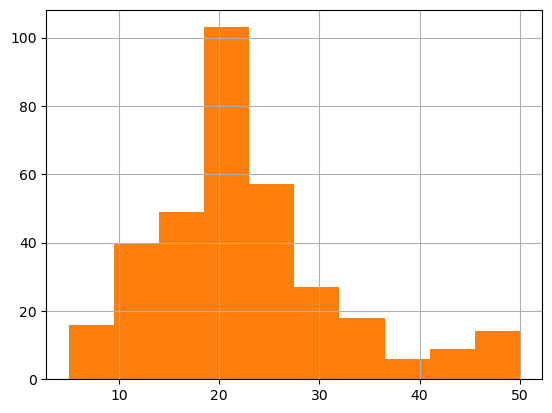

In [62]:
y_train.hist()
plt.show()

In [86]:
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

In [87]:
feature_standarizer = StandardScaler()
feature_standarizer.fit(y_train)

y_train_scaled = feature_standarizer.transform(y_train)
y_test_scaled = feature_standarizer.transform(y_test)
# y_train_scaled = pd.DataFrame(feature_standarizer.transform(y_train),
#                   columns=y_train.columns,
#                   index=y_train.index)
# y_test_scaled = pd.DataFrame(feature_standarizer.transform(y_test),
#                   columns=y_test.columns,
#                   index=y_test.index)

If you have binary/dummy variables the minmax scaler will not have any effect on the scale for the variable

### XGBoost

In [102]:
# XGBoost without scaling
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("R squared: ", model.score(X_test, y_test))
print('MSE ',np.sqrt(mean_squared_error(y_test,y_pred)))

Mean MAE: 2.504 (0.469)
R squared:  0.8100041431228978
MSE  3.783499224374951


In [93]:
# XGBoost with scaling
model = XGBRegressor()
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_scaled, y_train_scaled, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

Mean MAE: 0.271 (0.060)


In [101]:
model.fit(X_train_scaled, y_train_scaled)
y_pred = model.predict(X_test_scaled)
print("R squared: ", model.score(X_test_scaled, y_test_scaled))
print('MSE ',np.sqrt(mean_squared_error(y_test_scaled,y_pred)))

R squared:  0.7611917245748128
MSE  0.44990412972006927


### Linear Regression

In [ ]:
# define linear model
linear_reg = linear_model.LinearRegression()
model_lr = linear_reg.fit(X_train_scaled, X_train_scaled)
ypred = model_lr.predict(Xtest)
# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
# force scores to be positive
scores = abs(scores)
print('Mean MAE: %.3f (%.3f)' % (scores.mean(), scores.std()) )

In [ ]:
# Make Pipeline
# evaluation
# 
steps = list()
steps.append(('scaler', MinMaxScaler()))
steps.append(('model', LogisticRegression()))
pipeline = Pipeline(steps=steps)
# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model using cross-validation
scores = cross_val_score(pipeline, X, y, scoring='accuracy', cv=cv, n_jobs=-1)